In [31]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [5]:
# Step 1: Get Berlin Boundary
berlin_boundary = ox.geocode_to_gdf("Berlin, Germany")

In [6]:
# Step 2: Retrieve All Subdistricts (admin_level=10)
tags = {"boundary": "administrative", "admin_level": "10"}
subdistricts_gdf = ox.features_from_place("Berlin, Germany", tags)

In [7]:
# Check for missing values in each column
missing_values = subdistricts_gdf.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 geometry                      0
boundary                      0
name                        618
ref                         811
admin_level                   0
                           ... 
state_code                  919
alt_name:pt                 919
addr:postcode               919
ref:old                     918
admin_centre:postal_code    916
Length: 391, dtype: int64


In [8]:
# Check the data types of each column
print("Data types:\n", subdistricts_gdf.dtypes)

Data types:
 geometry                    geometry
boundary                      object
name                          object
ref                           object
admin_level                   object
                              ...   
state_code                    object
alt_name:pt                   object
addr:postcode                 object
ref:old                       object
admin_centre:postal_code      object
Length: 391, dtype: object


In [9]:
# Check for valid geometries
invalid_geometries = ~subdistricts_gdf.is_valid
print("Invalid geometries:\n", subdistricts_gdf[invalid_geometries])

# Optional: Fix invalid geometries
subdistricts_gdf['geometry'] = subdistricts_gdf['geometry'].buffer(0)

Invalid geometries:
 Empty GeoDataFrame
Columns: [geometry, boundary, name, ref, admin_level, name:ab, name:af, name:als, name:am, name:an, name:ang, name:ar, name:arc, name:arz, name:ast, name:az, name:ba, name:bar, name:bat-smg, name:be, name:be-tarask, name:bg, name:bi, name:bn, name:bo, name:br, name:bs, name:bxr, name:ca, name:cbk-zam, name:ckb, name:co, name:crh, name:cs, name:csb, name:cu, name:cv, name:cy, name:da, name:de, name:diq, name:dsb, name:el, name:en, name:eo, name:es, name:et, name:eu, name:ext, name:fa, name:fi, name:fo, name:fr, name:frp, name:fur, name:fy, name:ga, name:gan, name:gd, name:gl, name:gn, name:gv, name:haw, name:he, name:hi, name:hr, name:hsb, name:ht, name:hu, name:hy, name:ia, name:id, name:ie, name:ilo, name:io, name:is, name:it, name:iu, name:ja, name:jbo, name:jv, name:ka, name:kab, name:kbd, name:kk, name:kn, name:ko, name:koi, name:ksh, name:ku, name:kv, name:kw, name:ky, name:la, name:lb, name:lez, name:lg, name:li, name:lij, name:lmo, ...]
In

In [10]:
# Check CRS consistency
print("Berlin Boundary CRS:", berlin_boundary.crs)
print("Subdistricts CRS:", subdistricts_gdf.crs)

Berlin Boundary CRS: epsg:4326
Subdistricts CRS: epsg:4326


In [11]:
# Check for unique values in a specific column (e.g., 'name')
unique_names = subdistricts_gdf['name'].nunique()
print("Number of unique names:", unique_names)

# Check for duplicates
duplicates = subdistricts_gdf.duplicated(subset='name', keep=False)
print("Duplicate entries:\n", subdistricts_gdf[duplicates])

Number of unique names: 233
Duplicate entries:
                                                               geometry  \
element  id                                                              
relation 16328       POLYGON ((13.30038 52.56998, 13.3019 52.57144,...   
         16334       POLYGON ((13.2082 52.59899, 13.20724 52.59987,...   
         16343       POLYGON ((13.10932 52.45071, 13.10956 52.45108...   
         16347       POLYGON ((13.30154 52.54881, 13.30288 52.55045...   
         16566       POLYGON ((13.36586 52.53566, 13.36656 52.53591...   
...                                                                ...   
way      1311959245                                      POLYGON EMPTY   
         1311959246                                      POLYGON EMPTY   
         1314846088                                      POLYGON EMPTY   
         1314846089                                      POLYGON EMPTY   
         1333671988                                      POLYGON

In [12]:
# Display duplicates to understand their details
dup_names = subdistricts_gdf.duplicated(subset='name', keep=False)
print(subdistricts_gdf[dup_names][['name', 'admin_level', 'geometry']])

                              name admin_level  \
element  id                                      
relation 16328       Reinickendorf          10   
         16334       Reinickendorf           9   
         16343             Spandau           9   
         16347               Mitte           9   
         16566               Mitte          10   
...                            ...         ...   
way      1311959245            NaN          10   
         1311959246            NaN          10   
         1314846088            NaN          10   
         1314846089            NaN          10   
         1333671988            NaN          10   

                                                              geometry  
element  id                                                             
relation 16328       POLYGON ((13.30038 52.56998, 13.3019 52.57144,...  
         16334       POLYGON ((13.2082 52.59899, 13.20724 52.59987,...  
         16343       POLYGON ((13.10932 52.45071, 13.1095

In [13]:
# Drop exact duplicates
subdistricts_gdf = subdistricts_gdf.drop_duplicates(subset=['name', 'geometry'])

In [14]:
# Filter to a specific admin_level if needed
admin_level_10 = subdistricts_gdf[subdistricts_gdf['admin_level'] == '10']

In [15]:
# Step 3: Clip Subdistricts to Berlin Boundary (Optional)
subdistricts_clipped = gpd.clip(admin_level_10, berlin_boundary)

In [20]:
# Retrieve Bars and Restaurants
poi_tags = {"amenity": ["bar", "restaurant"]}
poi_gdf = ox.features_from_place("Berlin, Germany", poi_tags)

In [21]:
# Clip the POIs to Berlin boundary for relevance
poi_clipped = gpd.clip(poi_gdf, berlin_boundary)

In [26]:
subdistricts_clipped["area"] = subdistricts_clipped.area
subdistricts_clipped["bars_and_restaurants_count"] = subdistricts_clipped.apply(
    lambda row: poi_clipped.within(row['geometry']).sum(), axis=1
)
subdistricts_clipped["density"] = subdistricts_clipped['bars_and_restaurants_count'] / subdistricts_clipped['area']

/tmp/ipykernel_2296398/540760405.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  subdistricts_clipped["area"] = subdistricts_clipped.area


In [40]:
print(subdistricts_clipped[['name', 'density']].head())
print(subdistricts_clipped['density'].describe())

                         name       density
element  id                                
relation 151950   Schmöckwitz   3990.263049
         410444     Bohnsdorf   5803.553043
         151937        Grünau   5800.561483
         410443    Müggelheim   2040.846707
         162913  Altglienicke  13465.237995
count       104.000000
mean      49120.825374
std       86214.358425
min           0.000000
25%        6709.798986
50%       18355.630661
75%       40336.518649
max      443151.662289
Name: density, dtype: float64


In [35]:
subdistricts_clipped['density'] = subdistricts_clipped['density'].fillna(0)


In [43]:
vmin = subdistricts_clipped['density'].min()
vmax = subdistricts_clipped['density'].max()

# Ensure vmax is greater than vmin
if vmin == vmax:
    vmax = vmax + 1  # Increment vmax if they are equal to avoid divide by zero errors

In [44]:
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

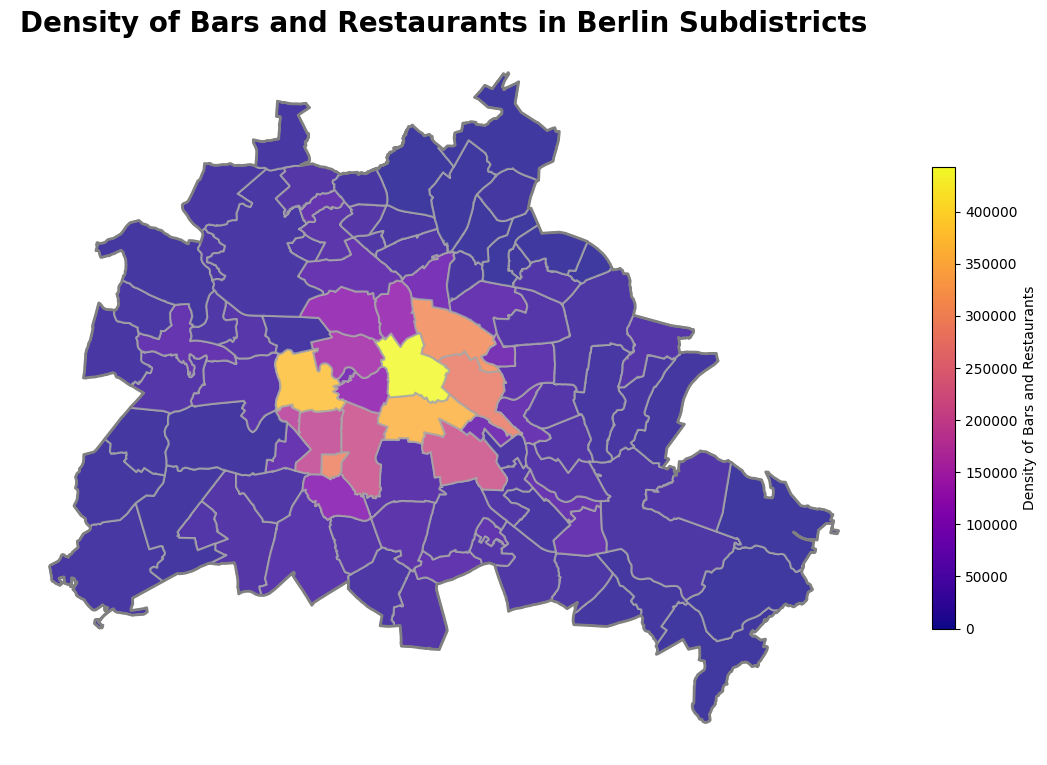

In [57]:
# Step 4: Plot Subdistricts
fig, ax = plt.subplots(figsize=(14, 12), dpi=100)
# Plot subdistricts with unique colors
cmap = "plasma"

# Customize legend
legend_kwds = {
    "shrink": 0.5,  # Adjust size
    "label": "Density of Bars and Restaurants",  # Add label
    "orientation": "vertical"  # Orientation
}

try:
  subdistricts_clipped.plot(
    ax=ax,
    column="density",  # Color based on name
    cmap=cmap,   # Colormap for distinct colors
    legend=True,
    alpha=0.8,
    edgecolor="darkgrey",
    linewidth =1.5,  # Add boundaries for subdistricts
    norm=norm if norm is not None else plt.Normalize(vmin, vmax),
    legend_kwds=legend_kwds

  
  )
except Exception as e:
  print("An error occured while plotting:", e)
# Plot Berlin boundary
berlin_boundary.boundary.plot(ax=ax, color="grey", linewidth=2)

# Title and Axis
plt.title("Density of Bars and Restaurants in Berlin Subdistricts", fontsize=20, weight="bold")
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)

# Remove axis ticks and borders
ax.axis("off")

plt.show()

In [46]:
# Check if the GeoDataFrame has any entries
print(f"Number of subdistricts after cleaning: {len(subdistricts_gdf)}")

Number of subdistricts after cleaning: 247
